# Dummy Modeling 

This notebook attempts to constrain the parameters a, b, c, d in a fake model with dependencies established by a model function mu. The primary goal is to represent higher order variances, as introduced by the flexion, quarxion, etc. from the DALI formalism. 

# 1 Import Statements

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import patches as patch

# 2 Constants

In [2]:
###############################################################################
n_param = 4

In [3]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = '#212121'
plt.rcParams['axes.labelcolor'] = '#212121'
plt.rcParams['xtick.color'] = '#212121'
plt.rcParams['ytick.color'] = '#212121'
plt.rcParams['text.color'] = '#212121'
plt.rcParams['savefig.facecolor'] = 'white'

# 3 Functions

## 3a Model Function and its PDEs

In [4]:
def mu(z, a, b, c, d):
    return z*a**3 + z**2*b**2 + np.exp(c*z) + np.sin(d*z) + a*b

In [5]:
def mu_a(z, a, b, c, d):
    return 3*z*a**2+b

def mu_b(z, a, b, c, d):
    return 2*z**2*b+a

def mu_c(z, a, b, c, d):
    return z*np.exp(c*z)

def mu_d(z, a, b, c, d):
    return z*np.cos(d*z)

In [6]:
def mu_aa(z, a, b, c, d):
    return 6*z*a

def mu_ab(z, a, b, c, d):
    return np.ones(z.shape)

def mu_ac(z, a, b, c, d):
    return np.zeros(z.shape)

def mu_ad(z, a, b, c, d):
    return np.zeros(z.shape)

def mu_bb(z, a, b, c, d):
    return 2*z**2

def mu_bc(z, a, b, c, d):
    return np.zeros(z.shape)

def mu_bd(z, a, b, c, d):
    return np.zeros(z.shape)

def mu_cc(z, a, b, c, d):
    return z**2*np.exp(c*z)

def mu_cd(z, a, b, c, d):
    return np.zeros(z.shape)

def mu_dd(z, a, b, c, d):
    return -z**2*np.sin(d*z)

In [7]:
def mu_aaa(z, a, b, c, d):
    return 6*z

def mu_aab(z, a, b, c, d):
    return np.zeros(z.shape)

def mu_aac(z, a, b, c, d):
    return np.zeros(z.shape)

def mu_aad(z, a, b, c, d):
    return np.zeros(z.shape)

def mu_abb(z, a, b, c, d):
    return np.zeros(z.shape)

def mu_abc(z, a, b, c, d):
    return np.zeros(z.shape)

def mu_abd(z, a, b, c, d):
    return np.zeros(z.shape)

def mu_acc(z, a, b, c, d):
    return np.zeros(z.shape)

def mu_acd(z, a, b, c, d):
    return np.zeros(z.shape)

def mu_add(z, a, b, c, d):
    return np.zeros(z.shape)

def mu_bbb(z, a, b, c, d):
    return np.zeros(z.shape)

def mu_bbc(z, a, b, c, d):
    return np.zeros(z.shape)

def mu_bbd(z, a, b, c, d):
    return np.zeros(z.shape)

def mu_bcc(z, a, b, c, d):
    return np.zeros(z.shape)

def mu_bcd(z, a, b, c, d):
    return np.zeros(z.shape)

def mu_bdd(z, a, b, c, d):
    return np.zeros(z.shape)

def mu_ccc(z, a, b, c, d):
    return z**3*np.exp(c*z)

def mu_ccd(z, a, b, c, d):
    return np.zeros(z.shape)

def mu_cdd(z, a, b, c, d):
    return np.zeros(z.shape)

def mu_ddd(z, a, b, c, d):
    return -z**3*np.cos(d*z)

In [8]:
def mu_operator(z, a, b, c, d, i=-1, j=-1, k=-1):
    '''
        where 0,1,2,3 correspond to a,b,c,d respectively
    '''
    mu_dir = [mu,
              [mu_a, mu_b, mu_c, mu_d],
              [[mu_aa, mu_ab, mu_ac, mu_ad],
               [mu_ab, mu_bb, mu_bc, mu_bd],
               [mu_ac, mu_bc, mu_cc, mu_cd],
               [mu_ad, mu_bd, mu_cd, mu_dd]],
              [[[mu_aaa, mu_aab, mu_aac, mu_aad],
                [mu_aab, mu_abb, mu_abc, mu_abd],
                [mu_aac, mu_abc, mu_acc, mu_acd],
                [mu_aad, mu_abd, mu_acd, mu_add]],
               [[mu_aab, mu_abb, mu_abc, mu_abd],
                [mu_abb, mu_bbb, mu_bbc, mu_bbd],
                [mu_abc, mu_bbc, mu_bcc, mu_bcd],
                [mu_abd, mu_bbd, mu_bcd, mu_bdd]],
               [[mu_aac, mu_abc, mu_acc, mu_acd],
                [mu_abc, mu_bbc, mu_bcc, mu_bcd],
                [mu_acc, mu_bcc, mu_ccc, mu_ccd],
                [mu_acd, mu_bcd, mu_ccd, mu_cdd]],
               [[mu_aad, mu_abd, mu_acd, mu_add],
                [mu_abd, mu_bbd, mu_bcd, mu_bdd],
                [mu_acd, mu_bcd, mu_ccd, mu_cdd],
                [mu_add, mu_bdd, mu_cdd, mu_ddd]]]]
    if i >= 0:
        if j >= 0:
            if k >= 0:
                return mu_dir[3][i][j][k](z, a, b, c, d)
            else:
                return mu_dir[2][i][j](z, a, b, c, d)
        else:
            return mu_dir[1][i](z, a, b, c, d)
    else:
        return mu_dir[0](z, a, b, c, d)

## 3b Multivariate Gaussians

In [27]:
def g(a, b, a0, b0, F, F_inv):
    norm = 1/(2*np.pi*np.sqrt(np.linalg.det(F)))
    curve = np.zeros((len(a), len(b)))
    for i, alpha in enumerate(a - a0):
        for j, beta in enumerate(b - b0):
            curve[j,i] = np.exp(-1/2 * (F_inv[0,0]*(alpha)**2 
                                        + (F_inv[0,1] + F_inv[1,0])*(alpha)*(beta) 
                                        + F_inv[1,1]*(beta)**2))
    return norm * curve

In [10]:
def g_a(a, b, a0, b0, F, F_inv, S, S_inv):
    g_F = g(a, b, a0, b0, F, F_inv)
    left = 1/np.linalg.det(S)
    right = 1/2 * (2*S_inv[0,0]*(a-a0) + (S_inv[1,0] + S_inv[0,1])*(b-b0))
    return g_F * (left - right)

In [11]:
def g_b(a, b, a0, b0, S, S_inv):
    g_F = g(a, b, a0, b0, S)
    left = 1/np.linalg.det(S)
    right = 1/2 * (2*S_inv[0,0]*(b-b0) + (S_inv[1,0] + S_inv[0,1])*(a-a0))
    return g_F * (left - right)

In [12]:
def confidence(C, ax, mean=[0,0]):
    x_var = np.sqrt((C[0,0] + C[1,1])/2 + np.sqrt((C[0,0] - C[1,1])**2/4 + (C[0,1])**2))
    y_var = np.sqrt((C[0,0] + C[1,1])/2 - np.sqrt((C[0,0] - C[1,1])**2/4 + (C[0,1])**2))
    alpha = [1.52, 2.48, 3.44]
    theta = (np.arctan((2*C[0,1])/(C[0,0] - C[1,1])))/2 * 180/np.pi
    colors = ['white', 'pink', 'gray']
    labels = ['$1\sigma$', '$2\sigma$', '$3\sigma$']
    for i in range(len(alpha)):
        ax.add_patch(patch.Ellipse(mean, alpha[i]*x_var, alpha[i]*y_var, 
                                   angle=theta, facecolor='none', 
                                   edgecolor=colors[i], label=labels[i], 
                                   linewidth=1.5))
    return x_var, y_var, alpha, theta

def plot_confidence(C, a0, b0, l, r, figsize=6,
                    figname='avb.png'):
    fig, ax = plt.subplots(figsize=(figsize, figsize))
    x_var, y_var, alpha, theta = confidence(C, ax, mean=(a0,b0))
    ax.set_xlim((l[0],r[0]))
    ax.set_ylim((l[1],r[1]))
    ax.set_xlabel('a')
    ax.set_ylabel('b')
    ax.legend()
    plt.title('a vs b Probability Space', size=16)

## 3c DALI Objects

Including the Fisher matrix, its derivative-analogue the Flexion, and its 2nd-derivative the Quarxion.

In [13]:
def F(z, p0, M, n=n_param):
    FISH = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            FISH[i,j] = np.matmul(np.matmul((mu_operator(z, p0[0], p0[1], p0[2], p0[3], i)).T, M), 
                                  mu_operator(z, p0[0], p0[1], p0[2], p0[3], j))
    return FISH

In [14]:
def S(z, p0, M, n=n_param):
    FLEX = np.zeros((n,n,n))
    for i in range(n):
        for j in range(n):
            for k in range(n):
                FLEX[i,j,k] = np.matmul(np.matmul((mu_operator(z, p0[0], p0[1], p0[2], p0[3], i, j)).T, M), 
                                        mu_operator(z, p0[0], p0[1], p0[2], p0[3], k))
                FLEX[i,j,k] += np.matmul(np.matmul((mu_operator(z, p0[0], p0[1], p0[2], p0[3], i, k)).T, M), 
                                         mu_operator(z, p0[0], p0[1], p0[2], p0[3], j))
                FLEX[i,j,k] += np.matmul(np.matmul((mu_operator(z, p0[0], p0[1], p0[2], p0[3], j, k)).T, M), 
                                         mu_operator(z, p0[0], p0[1], p0[2], p0[3], i))
    return FLEX

In [15]:
def Q(z, p0, M, n=n_param):
    QUAR = np.zeros((n,n,n,n))
    for i in range(n):
        for j in range(n):
            for k in range(n):
                for l in range(n):
                    QUAR[i,j,k,l] = np.matmul(np.matmul((mu_operator(z, p0[0], p0[1], p0[2], p0[3], i, j, k)).T, M), 
                                              mu_operator(z, p0[0], p0[1], p0[2], p0[3], l))
                    QUAR[i,j,k,l] += np.matmul(np.matmul((mu_operator(z, p0[0], p0[1], p0[2], p0[3], i, j, l)).T, M), 
                                               mu_operator(z, p0[0], p0[1], p0[2], p0[3], k))
                    QUAR[i,j,k,l] += np.matmul(np.matmul((mu_operator(z, p0[0], p0[1], p0[2], p0[3], i, k, l)).T, M), 
                                               mu_operator(z, p0[0], p0[1], p0[2], p0[3], j))
                    QUAR[i,j,k,l] += np.matmul(np.matmul((mu_operator(z, p0[0], p0[1], p0[2], p0[3], j, k, l)).T, M), 
                                               mu_operator(z, p0[0], p0[1], p0[2], p0[3], i))
                    QUAR[i,j,k,l] += np.matmul(np.matmul((mu_operator(z, p0[0], p0[1], p0[2], p0[3], i, j)).T, M), 
                                               mu_operator(z, p0[0], p0[1], p0[2], p0[3], k, l))
                    QUAR[i,j,k,l] += np.matmul(np.matmul((mu_operator(z, p0[0], p0[1], p0[2], p0[3], i, k)).T, M), 
                                               mu_operator(z, p0[0], p0[1], p0[2], p0[3], j, l))
                    QUAR[i,j,k,l] += np.matmul(np.matmul((mu_operator(z, p0[0], p0[1], p0[2], p0[3], i, l)).T, M), 
                                               mu_operator(z, p0[0], p0[1], p0[2], p0[3], j, k))
    return QUAR

## 3d Extra Functions

In [16]:
def dice(A, i, j, k=-1, l=-1):
    if k >= 0:
        if l >= 0:
            return np.array([[A[i,i,k,l], A[i,j,k,l]], [A[j,i,k,l], A[j,j,k,l]]])
        else:
            return np.array([[A[i,i,k], A[i,j,k]], [A[j,i,k], A[j,j,k]]])
    else:
        return np.array([[A[i,i], A[i,j]], [A[j,i], A[j,j]]])

# 4 Generating Data

In [17]:
res = 10**3
n_param = 4

l = np.array([-2,0,-2,0])
r = np.array([6,8,6,8])

a = np.linspace(l[0],r[0],res)
b = np.linspace(l[1],r[1],res)
c = np.linspace(l[2],r[2],res)
d = np.linspace(l[3],r[3],res)

a0 = 2
b0 = 4
c0 = 3
d0 = 3

In [29]:
p = np.array([a,b,c,d])
p0 = np.array([a0,b0,c0,d0])
labels = ['a','b','c','d']

In [23]:
n_var = 2*10**1
C = np.random.randint(10**4,size=(n_var,n_var))/(10**5)
for i in range(n_var): 
    while C[i,i] < 10**-1: C[i,i] *= 5*10**0
C = (C+C.T)/2
M = np.linalg.inv(C)

z = np.linspace(10**-2,10**0,n_var)

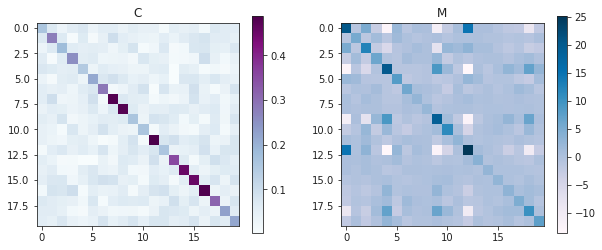

In [24]:
fig, ax = plt.subplots(1, 2)
im = ax[0].imshow(C, cmap='BuPu')
fig.colorbar(im, ax=ax[0])
ax[0].set_title('C')
im = ax[1].imshow(M, cmap='PuBu')
fig.colorbar(im, ax=ax[1])
ax[1].set_title('M')
fig.set_figheight(4)
fig.set_figwidth(10)
fig.savefig('figures/cm.png')

In [25]:
fisher = F(z, p0, M)
fisher_inv = np.linalg.inv(fisher)
flexion = S(z, p0, M)
flexion_inv = np.linalg.inv(flexion)
flexion_inv_avg = np.mean(flexion_inv, axis=1)
flexion_avg = np.mean(flexion, axis=1)
flexion_avg_inv = np.linalg.inv(flexion_avg)

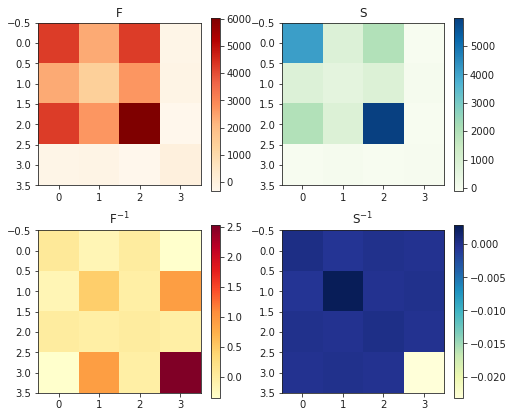

In [26]:
fig, ax = plt.subplots(2, 2)
im = ax[0,0].imshow(fisher, cmap='OrRd')
fig.colorbar(im, ax=ax[0,0])
ax[0,0].set_title('F')
im = ax[0,1].imshow(flexion_avg, cmap='GnBu')
fig.colorbar(im, ax=ax[0,1])
ax[0,1].set_title('S')
im = ax[1,0].imshow(fisher_inv, cmap='YlOrRd')
fig.colorbar(im, ax=ax[1,0])
ax[1,0].set_title('F$^{-1}$')
im = ax[1,1].imshow(flexion_avg_inv, cmap='YlGnBu')
fig.colorbar(im, ax=ax[1,1])
ax[1,1].set_title('S$^{-1}$')
fig.set_figheight(7)
fig.set_figwidth(8)
fig.savefig('figures/fsinv.png')

# 5 Plotting Parameter Spaces

## DALI

/Users/hansen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


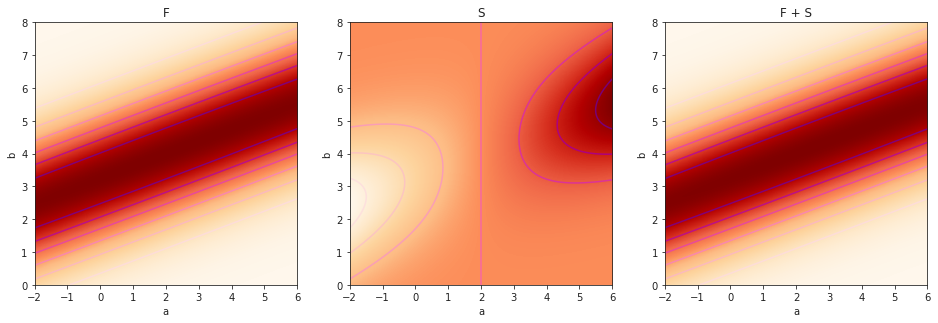

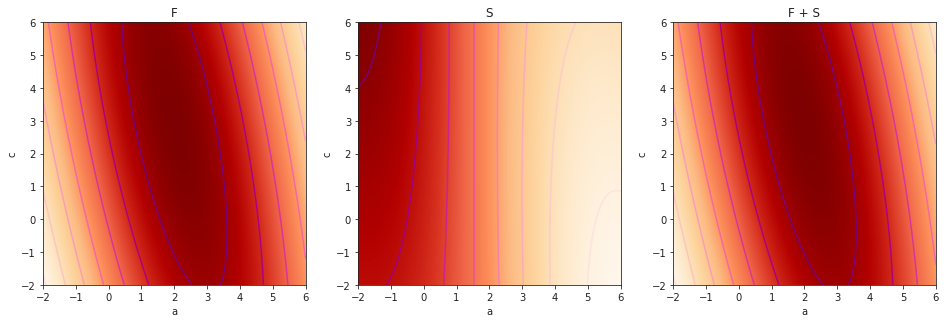

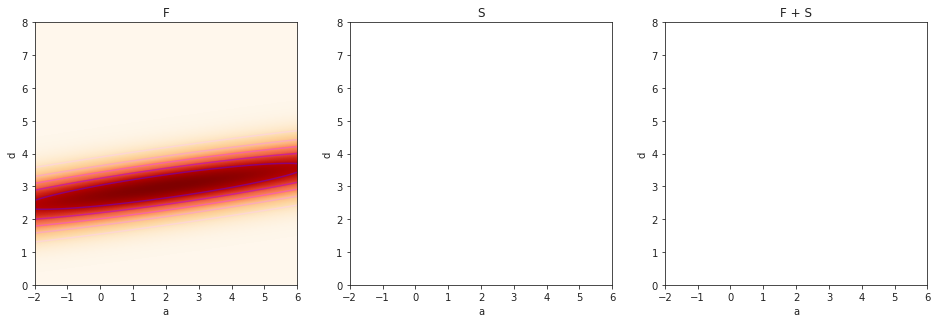

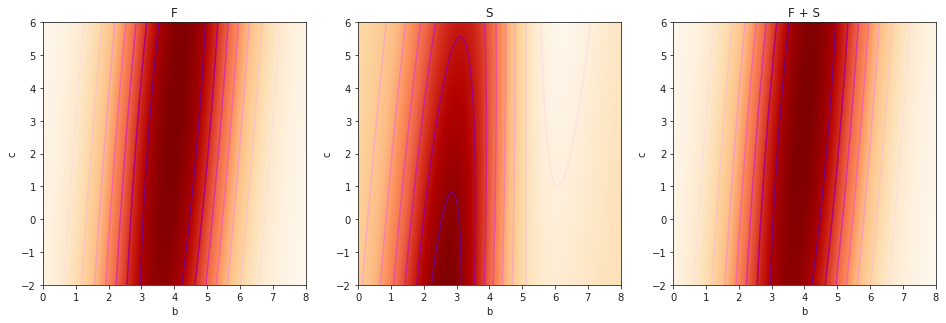

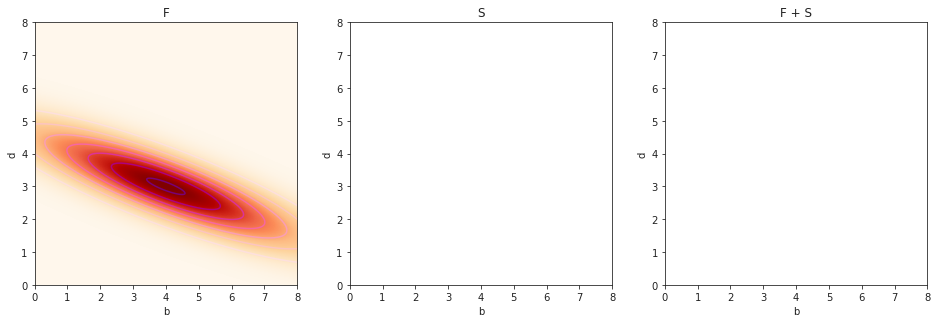

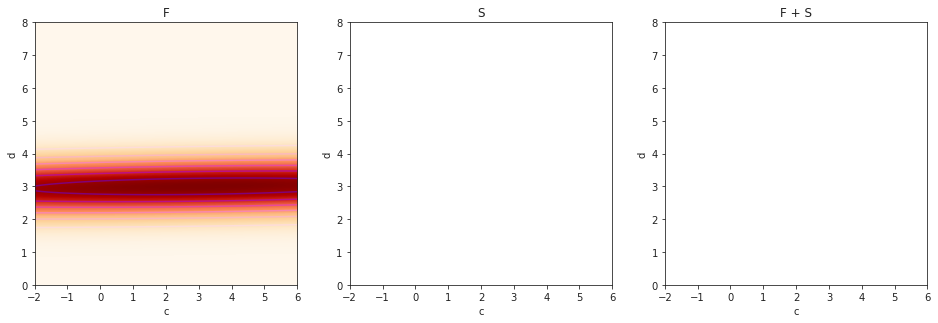

In [31]:
gaussians = []
gaussians_a = []

for i in range(4):
    for j in range(4):
        if i == j or j < i: continue
        gaussians.append(g(p[i], p[j], p0[i], p0[j], dice(fisher,i,j), dice(fisher_inv,i,j)))
        gaussians_a.append(g_a(p[i], p[j], p0[i], p0[j], dice(flexion_avg,i,j), dice(fisher_inv,i,j), 
                               dice(flexion_avg,i,j), dice(flexion_inv_avg,i,j)))
        fig, ax = plt.subplots(1,3)
        im = ax[0].imshow(gaussians[-1],
                          extent=[l[i],r[i],l[j],r[j]], 
                          aspect=(r[j]-l[j])/(r[i]-l[i]),
                          origin='lower', cmap='OrRd')
        ax[0].contour(gaussians[-1], cmap='RdPu', 
                      extent=[l[i],r[i],l[j],r[j]])
        ax[0].set_xlabel(labels[i])
        ax[0].set_ylabel(labels[j])
        ax[0].set_title('F')
        im = ax[1].imshow(gaussians_a[-1],
                          extent=[l[i],r[i],l[j],r[j]], 
                          aspect=(r[j]-l[j])/(r[i]-l[i]),
                          origin='lower', cmap='OrRd')
        ax[1].contour(gaussians_a[-1], cmap='RdPu', 
                      extent=[l[i],r[i],l[j],r[j]])
        ax[1].set_xlabel(labels[i])
        ax[1].set_ylabel(labels[j])
        ax[1].set_title('S')
        im = ax[2].imshow(gaussians[-1] + gaussians_a[-1],
                          extent=[l[i],r[i],l[j],r[j]], 
                          aspect=(r[j]-l[j])/(r[i]-l[i]),
                          origin='lower', cmap='OrRd')
        ax[2].contour(gaussians[-1] + gaussians_a[-1], cmap='RdPu', 
                      extent=[l[i],r[i],l[j],r[j]])
        ax[2].set_xlabel(labels[i])
        ax[2].set_ylabel(labels[j])
        ax[2].set_title('F + S')
        fig.set_figheight(6)
        fig.set_figwidth(16)
        fig.patch.set_facecolor('white')
        fig.savefig('figures/fs'+labels[i]+labels[j]+'.png')